In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# Reading train and test split datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
# Identifying categorical and numerical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Scaling numerical columns using minmaxscaler
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Storing mappings for label encoding to decode later while analyzing cluster
encoding_maps = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])  # Fit on train
    test_df[col] = le.transform(test_df[col])        # Transform test
    encoding_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))  # Store mapping

In [ ]:
# Function to computes a mixed distance matrix using euclidean for numerical and weighted hamming for categorical features

def compute_mixed_distance_matrix(X, categorical_indices, gamma=1):

    num_indices = [i for i in range(X.shape[1]) if i not in categorical_indices]

    # Splitting numerical and categorical data
    X_num = X[:, num_indices].astype(float)
    X_cat = X[:, categorical_indices].astype(str)  # Convert categorical values to strings

    # Computing Euclidean distance for numerical data
    euclidean_dist = pairwise_distances(X_num, metric='euclidean')

    # Computing Hamming distance for categorical data
    hamming_dist = pairwise_distances(X_cat, metric='hamming')

    # Combine distances with gamma weighting (default gamma = 1, can be tuned)
    return euclidean_dist + (gamma * hamming_dist)

In [ ]:
def compute_silhouette_score(X, categorical_indices, kproto_clusters, gamma=1):
    """Computes silhouette score for k-prototypes clustering using a mixed distance metric."""

    n_samples = X.shape[0]
    dist_matrix = compute_mixed_distance_matrix(X, categorical_indices, gamma)

    # Computing silhouette scores
    a = np.zeros(n_samples)
    b = np.zeros(n_samples)

    for i in range(n_samples):
        cluster_i = kproto_clusters[i]

        # Intra-cluster distance (a)
        same_cluster_mask = (kproto_clusters == cluster_i)
        a[i] = np.mean(dist_matrix[i, same_cluster_mask]) if np.sum(same_cluster_mask) > 1 else 0

        # Nearest-cluster distance (b)
        unique_clusters = np.unique(kproto_clusters)
        b_values = []

        for cluster in unique_clusters:
            if cluster != cluster_i:
                other_cluster_mask = (kproto_clusters == cluster)
                b_values.append(np.mean(dist_matrix[i, other_cluster_mask]))

        b[i] = min(b_values) if b_values else 0

    # Computing final silhouette scores
    silhouette_scores = (b - a) / np.maximum(a, b)

    return np.mean(silhouette_scores)

In [ ]:
# Converting to numpy array for k-prototypes
train_matrix = train_df.values
test_matrix = test_df.values
cat_indices = [train_df.columns.get_loc(col) for col in categorical_cols]

# Computing cost for different k using elbow method
cost = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    clusters = kproto.fit_predict(train_matrix, categorical=cat_indices)
    cost.append(kproto.cost_)

    # Compute silhouette score for plotting
    if k > 1:
        gamma = kproto.gamma  # Use K-Prototypes' internal weighting
        silhouette_scores.append(compute_silhouette_score(train_matrix, cat_indices, clusters, gamma))

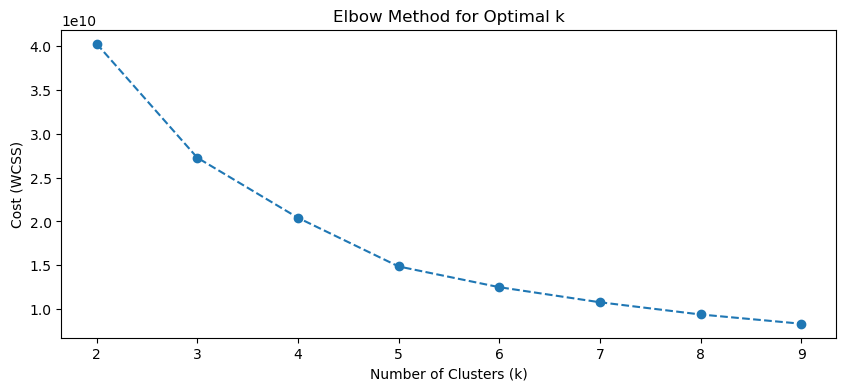

In [ ]:
# Plotting elbow method
plt.figure(figsize=(10, 4))
plt.plot(k_values, cost, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

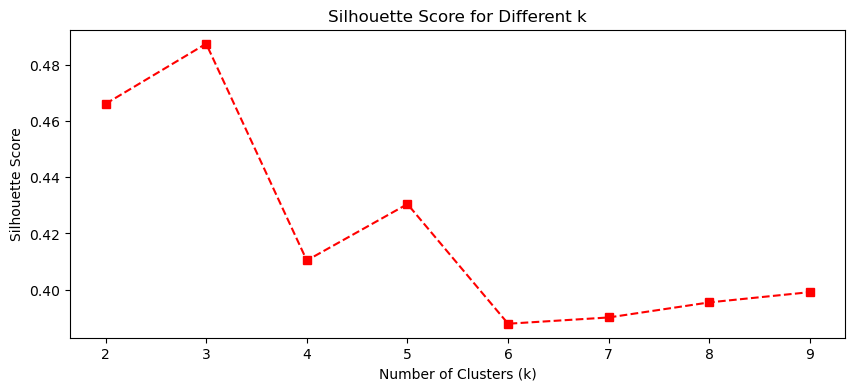

In [ ]:
# Plotting silhouette scores
plt.figure(figsize=(10, 4))
plt.plot(k_values[:len(silhouette_scores)], silhouette_scores, marker='s', linestyle='--', color='red')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()

### The highest silhouette score occurs at k=3, suggesting that three clusters provide the best separation.vFor the elbow method plot, the "elbow" is where the within-cluster sum of squares (WCSS) stops decreasing rapidly and levels off. Based on the above plot, the elbow appears to be around k=3 or k=4. Since both the silhouette score and elbow method suggest k=3 is a strong choice, we are going with 3 to be the most optimal number of clusters.

In [ ]:
# Choosing optimal k as 3
optimal_k = 3
kproto = KPrototypes(n_clusters=optimal_k, init='Cao', random_state=42)
train_clusters = kproto.fit_predict(train_matrix, categorical=cat_indices)
test_clusters = kproto.predict(test_matrix, categorical=cat_indices)

In [ ]:
# Computing test silhouette score
test_silhouette_score = compute_silhouette_score(test_matrix, cat_indices, test_clusters, gamma)
print(f"Silhouette Score on Test Data: {test_silhouette_score:.4f}")

Silhouette Score on Test Data: 0.4923


In [ ]:
# Adding cluster labels to datasets
train_df['Cluster'] = train_clusters
test_df['Cluster'] = test_clusters

In [ ]:
train_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion,Attrition,Cluster
0,47,2,1225,2,2,4,1,2,0,47,...,3,3,3,29,2,3,2,1,0,1
1,22,2,594,1,2,1,5,3,1,100,...,3,3,1,3,2,3,1,2,0,2
2,46,2,406,2,3,1,2,1,1,52,...,3,4,1,23,3,3,9,4,0,1
3,25,2,622,2,13,1,3,2,1,40,...,3,3,0,7,1,3,4,0,0,2
4,43,1,1001,1,9,5,3,4,1,72,...,3,2,1,10,3,3,7,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,23,2,427,2,7,3,1,3,1,99,...,4,2,1,3,2,3,2,0,1,2
1172,38,2,1009,2,2,2,1,2,0,31,...,3,4,1,11,3,3,7,1,0,2
1173,22,2,217,1,8,1,1,2,1,94,...,3,1,1,4,3,2,3,1,0,0
1174,36,2,430,1,2,4,4,4,0,73,...,4,4,1,15,2,3,0,0,0,2


In [ ]:
# Function to decode categorical values back to original labels
def decode_categorical(df, encoding_maps):
    df_decoded = df.copy()
    for col, mapping in encoding_maps.items():
        reverse_mapping = {v: k for k, v in mapping.items()}
        df_decoded[col] = df_decoded[col].map(reverse_mapping)
    return df_decoded

# Decoding train and test data
train_decoded = decode_categorical(train_df, encoding_maps)
test_decoded = decode_categorical(test_df, encoding_maps)

In [ ]:
train_decoded

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion,Attrition,Cluster
0,47,Travel_Rarely,1225,Sales,2,4,Life Sciences,2,Female,47,...,3,3,3,29,2,3,2,1,No,1
1,22,Travel_Rarely,594,Research & Development,2,1,Technical Degree,3,Male,100,...,3,3,1,3,2,3,1,2,No,2
2,46,Travel_Rarely,406,Sales,3,1,Marketing,1,Male,52,...,3,4,1,23,3,3,9,4,No,1
3,25,Travel_Rarely,622,Sales,13,1,Medical,2,Male,40,...,3,3,0,7,1,3,4,0,No,2
4,43,Travel_Frequently,1001,Research & Development,9,5,Medical,4,Male,72,...,3,2,1,10,3,3,7,4,No,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,23,Travel_Rarely,427,Sales,7,3,Life Sciences,3,Male,99,...,4,2,1,3,2,3,2,0,Yes,2
1172,38,Travel_Rarely,1009,Sales,2,2,Life Sciences,2,Female,31,...,3,4,1,11,3,3,7,1,No,2
1173,22,Travel_Rarely,217,Research & Development,8,1,Life Sciences,2,Male,94,...,3,1,1,4,3,2,3,1,No,0
1174,36,Travel_Rarely,430,Research & Development,2,4,Other,4,Female,73,...,4,4,1,15,2,3,0,0,No,2


In [ ]:
# Function to analyze clusters
def analyze_clusters(df, categorical_cols, numerical_cols, dataset_name="Dataset"):
    print(f"\n====== {dataset_name} Cluster Analysis ======\n")

    # Cluster size distribution
    print("Cluster Size Distribution:\n", df['Cluster'].value_counts(), "\n")

    # Summary statistics for numerical features
    print("\nNumerical Feature Summary by Cluster:")
    print(df.groupby('Cluster')[numerical_cols].agg(['mean', 'std', 'median']))

    # Category distribution for each cluster
    print("\nCategorical Feature Distribution by Cluster:")
    for col in categorical_cols:
        print(f"\nFeature: {col}")
        print(df.groupby('Cluster')[col].value_counts(normalize=True))  # Relative frequencies
        print("-" * 50)

analyze_clusters(train_decoded, categorical_cols, numerical_cols, "Train Data")


====== Train Data Cluster Analysis ======

Cluster Size Distribution:
 Cluster
0    511
2    498
1    167
Name: count, dtype: int64 


Numerical Feature Summary by Cluster:
               Age                    DailyRate                     \
              mean       std median        mean         std median   
Cluster                                                              
0        35.273973  8.180038   34.0  806.301370  406.051213  805.0   
1        46.311377  7.275064   47.0  827.784431  407.270301  810.0   
2        35.644578  8.875632   34.0  793.642570  394.858109  774.5   

        DistanceFromHome                  Education  ...  \
                    mean       std median      mean  ...   
Cluster                                              ...   
0               9.318982  8.161243    7.0  2.939335  ...   
1               9.233533  8.969121    6.0  2.970060  ...   
2               9.439759  7.934426    7.0  2.851406  ...   

        TrainingTimesLastYear WorkLifeBalanc

## Cluster 0: Young & Mid-Level Employees in Sales & R&D

Key Characteristics:
Size: 511 employees (largest group)
Age: 35.3 years (youngest cluster)
Job Roles: Sales Executives (24.9%), Research Scientists (23.1%), Laboratory Technicians (21.7%)
Department: Mostly R&D (64.6%), followed by Sales (30.5%)
Education Field: Balanced mix, with many from Life Sciences (39.3%) and Medical (30.5%)
Years in Current Role: 3.9 years (shorter tenure)
Years Since Last Promotion: 1.8 years (least experienced)
Overtime: 26.4% work overtime (lowest among clusters)
Attrition Rate: 17.2% (higher than Cluster 1, slightly better than Cluster 2)
Attrition Drivers & Remedies:
1. Career Growth & Development

Issue: Employees are early in their careers with fewer promotions.
Solution: Implement structured career progression plans, internal mobility programs, and leadership development training.
2. Engagement & Job Satisfaction

Issue: Many employees in sales roles may experience performance pressure and burnout.
Solution: Introduce mentorship programs, flexible work arrangements, and performance-based incentives.
3. Compensation & Work-Life Balance

Issue: Some employees may feel underpaid relative to their effort.
Solution: Regular compensation benchmarking and non-monetary benefits like professional development stipends.
Retention Strategy:

⭐ Create a clear path for promotions & skill development to keep employees engaged and invested in the company.

## Cluster 1: Senior Managers & Tenured Employees (Low Attrition)

Key Characteristics:
Size: 167 employees (smallest group)
Age: 46.3 years (oldest, most experienced)
Job Roles: Managers (45.5%) and Research Directors (30.5%)
Department: Majority in R&D (67%)
Years in Current Role: 6 years (longest tenure)
Years Since Last Promotion: 4 years (delayed promotions)
Overtime: 34.1% work overtime (highest among clusters)
Attrition Rate: 7.8% (lowest, most stable group)
Attrition Drivers & Remedies:
1. Career Plateau & Lack of New Challenges

Issue: Employees are in senior roles but may feel stagnant due to lack of advancement.
Solution: Offer executive training programs, cross-functional projects, and leadership opportunities to keep them engaged.
2. Workload & Burnout

Issue: High overtime levels suggest workload strain.
Solution: Delegate tasks, encourage work-life balance, and consider workload distribution across teams.
3. Retirement & Succession Planning

Issue: Some employees may consider early retirement or job transitions due to age.
Solution: Establish succession planning, offer consulting roles post-retirement, and introduce knowledge transfer initiatives.
Retention Strategy:

⭐ Keep senior employees engaged by providing leadership responsibilities & ensuring work-life balance.

## Cluster 2: Young to Mid-Level Employees with High Attrition

Key Characteristics:
Size: 498 employees
Age: 35.6 years (similar to Cluster 0)
Job Roles: Sales Executives (25.7%), Laboratory Technicians (20.9%), Research Scientists (20.5%)
Department: R&D (64.6%) and Sales (32.1%)
Years in Current Role: 3.9 years
Years Since Last Promotion: 2.0 years
Overtime: 29.7% work overtime
Attrition Rate: 17.9% (highest among all clusters)
Attrition Drivers & Remedies:
1. Job Role Mismatch & Career Satisfaction

Issue: Employees in technical and sales roles may lack long-term career satisfaction.
Solution: Provide internal mobility opportunities where employees can explore different roles within the company.
2. Limited Advancement Opportunities

Issue: Employees have been in their roles for nearly 4 years but receive fewer promotions.
Solution: Implement a structured career roadmap, performance-based promotions, and clearer growth trajectories.
3. Compensation & Work Environment

Issue: Employees may feel under-compensated, leading to job switching.
Solution: Enhance monetary incentives (bonuses, stock options) and workplace engagement initiatives.
Retention Strategy:

⭐ Enhance career growth opportunities and compensation to reduce attrition in technical & sales roles.


In [ ]:
# Save clustered datasets
train_decoded.to_csv('train_kprototypes_clustered.csv', index=False)
test_decoded.to_csv('test_kprototypes_clustered.csv', index=False)

# Print cluster distribution
print(train_df['Cluster'].value_counts())
print(test_df['Cluster'].value_counts())

Cluster
0    511
2    498
1    167
Name: count, dtype: int64
Cluster
0    133
2    123
1     38
Name: count, dtype: int64


##Logistic Regression

In [ ]:
# Read in train and test csvs
train_df = pd.read_csv('train_kprototypes_clustered.csv')
test_df = pd.read_csv('test_kprototypes_clustered.csv')

# Split for cross-validation set
train_df, cv_df = train_test_split(train_df, test_size=0.2, random_state=5)

In [ ]:
# Make dummy columns for categorical variables
categorical_columns = train_df.select_dtypes(include=['object']).columns

# Exclude target variable
categorical_columns = categorical_columns[categorical_columns != 'Attrition']

train_df_encoded = pd.get_dummies(train_df, columns=categorical_columns,
                                  drop_first=True)
cv_df_encoded = pd.get_dummies(cv_df, columns=categorical_columns,
                                  drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_columns,
                                 drop_first=True)

# Re-add the 'Attrition' column after encoding
train_df_encoded['Attrition'] = train_df['Attrition']
cv_df_encoded['Attrition'] = cv_df['Attrition']
test_df_encoded['Attrition'] = test_df['Attrition']

# Ensure all columns are numeric (convert boolean True/False to 1/0)
train_df_encoded = train_df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))
cv_df_encoded = cv_df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))
test_df_encoded = test_df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))

train_df_encoded['Attrition'] = train_df_encoded['Attrition'].map({'No': 0, 'Yes': 1})
cv_df_encoded['Attrition'] = cv_df_encoded['Attrition'].map({'No': 0, 'Yes': 1})
test_df_encoded['Attrition'] = test_df_encoded['Attrition'].map({'No': 0, 'Yes': 1})


# Align the columns of cv_df and test_df with train_df (ensure same dummy columns in both)
cv_df_encoded = cv_df_encoded.reindex(columns=train_df_encoded.columns,
                                          fill_value=0)
test_df_encoded = test_df_encoded.reindex(columns=train_df_encoded.columns,
                                          fill_value=0)

<ipython-input-119-94e4f15e2484>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_df_encoded = train_df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))
<ipython-input-119-94e4f15e2484>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cv_df_encoded = cv_df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))
<ipython-input-119-94e4f15e2484>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_df_encoded = test_df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))


In [ ]:
# Check columns updaeted correctly
train_df_encoded.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'Attrition', 'Cluster', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Male', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive'

In [ ]:
cv_df_encoded.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'Attrition', 'Cluster', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Male', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive'

In [ ]:
test_df_encoded.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'Attrition', 'Cluster', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Male', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive'

In [ ]:
# Seperate the data based on clusters

train_0 = train_df_encoded[train_df['Cluster'] == 0]
train_1 = train_df_encoded[train_df['Cluster'] == 1]
train_2 = train_df_encoded[train_df['Cluster'] == 2]

cv_0 = cv_df_encoded[cv_df['Cluster'] == 0]
cv_1 = cv_df_encoded[cv_df['Cluster'] == 1]
cv_2 = cv_df_encoded[cv_df['Cluster'] == 2]

test_0 = test_df_encoded[test_df['Cluster'] == 0]
test_1 = test_df_encoded[test_df['Cluster'] == 1]
test_2 = test_df_encoded[test_df['Cluster'] == 2]

In [ ]:
# Add constants --> make X and Y data frames
y_0 = train_0['Attrition']
y_0_cv = cv_0['Attrition']
y_0_test = test_0['Attrition']

train_0 = train_0.drop(columns=['Cluster', 'Attrition'])
cv_0 = cv_0.drop(columns=['Cluster', 'Attrition'])
test_0 = test_0.drop(columns=['Cluster', 'Attrition'])

X_0 = sm.add_constant(train_0)
X_cv_0 = sm.add_constant(cv_0)
X_test_0 = sm.add_constant(test_0)

y_1 = train_1['Attrition']
y_1_cv = cv_1['Attrition']
y_1_test = test_1['Attrition']

train_1 = train_1.drop(columns=['Cluster', 'Attrition'])
cv_1 = cv_1.drop(columns=['Cluster', 'Attrition'])
test_1 = test_1.drop(columns=['Cluster', 'Attrition'])

X_1 = sm.add_constant(train_1)
X_cv_1 = sm.add_constant(cv_1)
X_test_1 = sm.add_constant(test_1)

y_2 = train_2['Attrition']
y_2_cv = cv_2['Attrition']
y_2_test = test_2['Attrition']

train_2 = train_2.drop(columns=['Cluster', 'Attrition'])
cv_2 = cv_2.drop(columns=['Cluster', 'Attrition'])
test_2 = test_2.drop(columns=['Cluster', 'Attrition'])

X_2 = sm.add_constant(train_2)
X_cv_2 = sm.add_constant(cv_2)
X_test_2 = sm.add_constant(test_2)

In [ ]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

def forward_selection(X, y):
    initial_features = X.columns.tolist()
    best_aic = np.inf
    current_features = []

    while True:
        aic_with_candidates = []
        for feature in initial_features:
            if feature not in current_features:
                try:
                    model = sm.Logit(y, X[current_features + [feature]]).fit(disp = 0)
                    aic_with_candidates.append((model.aic, feature))
                except np.linalg.LinAlgError:
                    #print(f"Skipping {feature} due to singular matrix error.")
                    continue

        if not aic_with_candidates:
            break

        aic_with_candidates.sort()  # Sort by AIC value (lowest AIC is preferred)

        best_aic_new, best_feature = aic_with_candidates[0]

        if best_aic_new < best_aic:
            best_aic = best_aic_new
            current_features.append(best_feature)
            #print(f'Added {best_feature}, AIC: {best_aic}')
        else:
            break  # No further improvement, stop the process

    return current_features


In [ ]:
# Find the model with the lowest AIC for Cluster 0
best_features_0 = forward_selection(X_0, y_0)

In [ ]:
best_features_0

['JobSatisfaction',
 'TotalWorkingYears',
 'MaritalStatus_Single',
 'OverTime_Yes',
 'EnvironmentSatisfaction',
 'DistanceFromHome',
 'NumCompaniesWorked',
 'BusinessTravel_Travel_Frequently',
 'RelationshipSatisfaction',
 'YearsSinceLastPromotion',
 'BusinessTravel_Travel_Rarely',
 'JobRole_Research Scientist',
 'WorkLifeBalance',
 'MonthlyRate',
 'EducationField_Other']

In [ ]:
# Run the best model
X_best_0 = X_0[best_features_0]
X_best_0 = sm.add_constant(X_best_0)
model_0 = sm.Logit(y_0, X_best_0).fit()
print(model_0.summary())

Optimization terminated successfully.
         Current function value: 0.286100
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                  418
Model:                          Logit   Df Residuals:                      402
Method:                           MLE   Df Model:                           15
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                  0.3441
Time:                        07:30:25   Log-Likelihood:                -119.59
converged:                       True   LL-Null:                       -182.32
Covariance Type:            nonrobust   LLR p-value:                 1.646e-19
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                1.2743      1.306      0.97

In [ ]:
print("AIC:", model_0.aic)

AIC: 271.1799092389736


In [ ]:
# Get model accuracy
y_pred_prob = model_0.predict(X_best_0)

# Convert predicted probabilities to binary predictions (threshold of 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate accuracy by comparing predicted labels with actual labels
accuracy = (y_pred == y_0).mean()

# Print accuracy
print(f"Train Accuracy: {accuracy:.4f}")


Train Accuracy: 0.8923


In [ ]:
# Get model accuracy on test data
X_test_best_0 = X_test_0[best_features_0]
X_test_best_0 = sm.add_constant(X_test_best_0)

y_pred_prob = model_0.predict(X_test_best_0)

# Convert predicted probabilities to binary predictions (threshold of 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate accuracy by comparing predicted labels with actual labels
accuracy = (y_pred == y_0_test).mean()

# Print accuracy
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8045


In [ ]:
X_cv_best_0 = X_cv_0[best_features_0]
X_best_0 = X_best_0.drop(columns = ["const"])

# Create a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)


param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength (inverse of regularization)
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers for optimization
    'max_iter': [100, 200, 500]  # Max iterations for solvers
}


# Now proceed with GridSearchCV and other parts of the code
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_cv_best_0, y_0_cv)

# Get the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best hyperparameters from GridSearchCV: {best_params}")

# Evaluate the best model on the cross-validation set
best_model = grid_search.best_estimator_

# Predict and evaluate on the cross-validation set
y_pred_cv = best_model.predict(X_cv_best_0)
accuracy = accuracy_score(y_0_cv, y_pred_cv)

# Output the accuracy on the cross-validation set
print(f"Accuracy on the cross-validation set: {accuracy:.4f}")

# #valuate on the training set as well
y_pred_train = best_model.predict(X_best_0)
train_accuracy = accuracy_score(y_0, y_pred_train)
print(f"Accuracy on the training set: {train_accuracy:.4f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters from GridSearchCV: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on the cross-validation set: 0.7634
Accuracy on the training set: 0.8421


In [ ]:
# Predict and evaluate on the test set
X_test_best_0 = X_test_best_0.drop(columns = ["const"])
y_pred_test = best_model.predict(X_test_best_0)
accuracy = accuracy_score(y_0_test, y_pred_test)

# Output the accuracy on the cross-validation set
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.8195


In [ ]:
# Fit the model using statsmodels for AIC calculation
logit_model = sm.Logit(y_0, X_0)
logit_result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.264962
         Iterations 27


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [ ]:
print(f"AIC of the best model: {logit_result.aic}")

AIC of the best model: 301.508494043994


For cluster 0, we see that cross-validation for hyper-parameter tuning increased AIC but improved test accuracy, with approximately a 1.5% increase.

In [ ]:
# Find the model with the lowest AIC for Cluster 1
best_features_1 = forward_selection(X_1, y_1)

In [ ]:
best_features_1.remove('const')
best_features_1

['MonthlyIncome',
 'OverTime_Yes',
 'Education',
 'EnvironmentSatisfaction',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'EducationField_Marketing',
 'EducationField_Life Sciences',
 'JobRole_Sales Executive']

In [ ]:
# Run the best model
X_best_1 = X_1[best_features_1]
X_best_1 = sm.add_constant(X_best_1)
model_1 = sm.Logit(y_1, X_best_1).fit()
print(model_1.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                   1.000
Time:                        07:44:16   Log-Likelihood:            -1.5854e-05
converged:                      False   LL-Null:                       -32.348
Covariance Type:            nonrobust   LLR p-value:                 1.654e-10
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -994.6375   1.96e+04     -0.051      0.960   -3.94e+04    3.74e+04
MonthlyInco

In [ ]:
print("AIC:", model_1.aic)

AIC: 20.000031708656024


In [ ]:
# Get model accuracy
y_pred_prob = model_1.predict(X_best_1)

# Convert predicted probabilities to binary predictions (threshold of 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate accuracy by comparing predicted labels with actual labels
accuracy = (y_pred == y_1).mean()

# Print accuracy
print(f"Train Accuracy: {accuracy:.4f}")


Train Accuracy: 1.0000


In [ ]:
# Get model accuracy on test data
X_test_best_1 = X_test_1[best_features_1]
X_test_best_1 = sm.add_constant(X_test_best_1)

y_pred_prob = model_1.predict(X_test_best_1)

# Convert predicted probabilities to binary predictions (threshold of 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate accuracy by comparing predicted labels with actual labels
accuracy = (y_pred == y_1_test).mean()

# Print accuracy
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9474


In [ ]:
X_cv_best_1 = X_cv_1[best_features_1]
X_best_1 = X_best_1.drop(columns = ["const"])

# Fit the grid search to the training data
grid_search.fit(X_cv_best_1, y_1_cv)

# Get the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best hyperparameters from GridSearchCV: {best_params}")

# Evaluate the best model on the cross-validation set
best_model = grid_search.best_estimator_

# Predict and evaluate on the cross-validation set
y_pred_cv = best_model.predict(X_cv_best_1)
accuracy = accuracy_score(y_1_cv, y_pred_cv)

# Output the accuracy on the cross-validation set
print(f"Accuracy on the cross-validation set: {accuracy:.4f}")

# #valuate on the training set as well
y_pred_train = best_model.predict(X_best_1)
train_accuracy = accuracy_score(y_1, y_pred_train)
print(f"Accuracy on the training set: {train_accuracy:.4f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters from GridSearchCV: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on the cross-validation set: 0.9048
Accuracy on the training set: 0.9280


In [ ]:
# Predict and evaluate on the test set
X_test_best_1 = X_test_best_1.drop(columns = ["const"])
y_pred_test = best_model.predict(X_test_best_1)
accuracy = accuracy_score(y_1_test, y_pred_test)

# Output the accuracy on the cross-validation set
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9474


For cluster 1, cross-validation didn't improve the test accuracy but it did reduce overfitting.

In [ ]:
# Find the model with the lowest AIC for Cluster 0
best_features_2 = forward_selection(X_2, y_2)

In [ ]:
best_features_2

['Age',
 'OverTime_Yes',
 'YearsInCurrentRole',
 'BusinessTravel_Travel_Frequently',
 'StockOptionLevel',
 'DistanceFromHome',
 'JobRole_Sales Representative',
 'NumCompaniesWorked',
 'RelationshipSatisfaction',
 'JobRole_Laboratory Technician',
 'JobRole_Human Resources',
 'JobRole_Sales Executive',
 'JobInvolvement',
 'BusinessTravel_Travel_Rarely',
 'EnvironmentSatisfaction',
 'DailyRate',
 'JobRole_Research Scientist',
 'YearsSinceLastPromotion',
 'Gender_Male',
 'JobRole_Manager',
 'JobSatisfaction',
 'WorkLifeBalance',
 'Department_Research & Development',
 'EducationField_Technical Degree']

In [ ]:
# Run the best model
X_best_2 = X_2[best_features_2]
X_best_2 = sm.add_constant(X_best_2)
model_2 = sm.Logit(y_2, X_best_2).fit()
print(model_2.summary())

         Current function value: 0.228070
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                  397
Model:                          Logit   Df Residuals:                      372
Method:                           MLE   Df Model:                           24
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                  0.4884
Time:                        07:54:13   Log-Likelihood:                -90.544
converged:                      False   LL-Null:                       -176.98
Covariance Type:            nonrobust   LLR p-value:                 1.663e-24
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                               -13.1444   4134.746     -0.003      0.997   -8117.098    8090.

In [ ]:
print("AIC:", model_2.aic)

AIC: 231.08766936616257


In [ ]:
# Get model accuracy
y_pred_prob = model_2.predict(X_best_2)

# Convert predicted probabilities to binary predictions (threshold of 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate accuracy by comparing predicted labels with actual labels
accuracy = (y_pred == y_2).mean()

# Print accuracy
print(f"Train Accuracy: {accuracy:.4f}")


Train Accuracy: 0.9194


In [ ]:
# Get model accuracy on test data
X_test_best_2 = X_test_2[best_features_2]
X_test_best_2 = sm.add_constant(X_test_best_2)

y_pred_prob = model_2.predict(X_test_best_2)

# Convert predicted probabilities to binary predictions (threshold of 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate accuracy by comparing predicted labels with actual labels
accuracy = (y_pred == y_2_test).mean()

# Print accuracy
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8455


In [ ]:
X_cv_best_2 = X_cv_2[best_features_2]
X_best_2 = X_best_2.drop(columns = ["const"])

# Fit the grid search to the training data
grid_search.fit(X_cv_best_2, y_2_cv)

# Get the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best hyperparameters from GridSearchCV: {best_params}")

# Evaluate the best model on the cross-validation set
best_model = grid_search.best_estimator_

# Predict and evaluate on the cross-validation set
y_pred_cv = best_model.predict(X_cv_best_2)
accuracy = accuracy_score(y_2_cv, y_pred_cv)

# Output the accuracy on the cross-validation set
print(f"Accuracy on the cross-validation set: {accuracy:.4f}")

# #valuate on the training set as well
y_pred_train = best_model.predict(X_best_2)
train_accuracy = accuracy_score(y_2, y_pred_train)
print(f"Accuracy on the training set: {train_accuracy:.4f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters from GridSearchCV: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on the cross-validation set: 0.9010
Accuracy on the training set: 0.8388


In [ ]:
# Predict and evaluate on the test set
X_test_best_2 = X_test_best_2.drop(columns = ["const"])
y_pred_test = best_model.predict(X_test_best_2)
accuracy = accuracy_score(y_2_test, y_pred_test)

# Output the accuracy on the cross-validation set
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.7886


For cluster 2, cross-validation decreased the test accuracy. Logistic regression performed the best on cluster 1.

### TREE MODELS

In [ ]:
# Read in train and test csvs
train_df = pd.read_csv('train_kprototypes_clustered.csv')
test_df = pd.read_csv('test_kprototypes_clustered.csv')

# Split for cross-validation set
train_df, cv_df = train_test_split(train_df, test_size=0.2, random_state=41)

In [ ]:
#One Hot encoding variables

### add in new caragorical column names that just changed! + cluster counts changed
categorical_columns = [
    'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
    'MaritalStatus', 'OverTime'
]
# Convert categorical columns to dummy variables (one-hot encoding)
train_df_encoded = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_columns, drop_first=True)

# Ensure both train and test have the same columns
missing_cols = set(train_df_encoded.columns) - set(test_df_encoded.columns)
for col in missing_cols:
    test_df_encoded[col] = 0

# Split the datasets into three clusters
train_clusters = {i: train_df_encoded[train_df_encoded['Cluster'] == i].drop(columns=['Cluster']) for i in range(3)}
test_clusters = {i: test_df_encoded[test_df_encoded['Cluster'] == i].drop(columns=['Cluster']) for i in range(3)}


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
# Function to train models
def train_model(df_train, cluster_id):
    X_train = df_train.drop(columns=['Attrition'])  # Features
    y_train = df_train['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)  # Target

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=41)
    cross_validate_model(rf, X_train, y_train, cluster_id)
    rf.fit(X_train, y_train)

    # Train Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=41)
    cross_validate_model(gb, X_train, y_train, cluster_id)
    gb.fit(X_train, y_train)

    return rf, gb

# Function to test models
def test_model(rf, gb, df_test, cluster_id):
    X_test = df_test.drop(columns=['Attrition'])
    y_test = df_test['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Test Random Forest
    y_pred_rf = rf.predict(X_test)
    print(f"Cluster {cluster_id} - Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

    # Test Gradient Boosting
    y_pred_gb = gb.predict(X_test)
    print(f"Cluster {cluster_id} - Gradient Boosting Test Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")

# Train and test models for each cluster
for i in range(3):
    rf_model, gb_model = train_model(train_clusters[i], i)
    test_model(rf_model, gb_model, test_clusters[i], i)


Cluster 0 - RandomForestClassifier Cross-Validation Accuracy: 0.8236 (+/- 0.0088)
Cluster 0 - GradientBoostingClassifier Cross-Validation Accuracy: 0.8005 (+/- 0.0340)
Cluster 0 - Random Forest Test Accuracy: 0.8120
Cluster 0 - Gradient Boosting Test Accuracy: 0.8045
Cluster 1 - RandomForestClassifier Cross-Validation Accuracy: 0.9319 (+/- 0.0149)
Cluster 1 - GradientBoostingClassifier Cross-Validation Accuracy: 0.9245 (+/- 0.0230)
Cluster 1 - Random Forest Test Accuracy: 0.9474
Cluster 1 - Gradient Boosting Test Accuracy: 0.9474
Cluster 2 - RandomForestClassifier Cross-Validation Accuracy: 0.8490 (+/- 0.0215)
Cluster 2 - GradientBoostingClassifier Cross-Validation Accuracy: 0.8465 (+/- 0.0194)
Cluster 2 - Random Forest Test Accuracy: 0.8211
Cluster 2 - Gradient Boosting Test Accuracy: 0.8211


In [ ]:
#add confusion matrices